# Krypton analysis 

## Lifetime

## Imports

In [1]:
import os
import glob
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-03-16 09:16:50


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string
from invisible_cities.icaro. hst_functions import plot_writer

from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import fit_slices_2d_expo
from icaro.core.fit_functions import expo_seed, gauss_seed
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

In [4]:
from typing      import NamedTuple
from typing      import Tuple

In [6]:
from core.kr_functions import KrEvent, KrRanges, KrNBins, KrBins, KrFit, Ranges

In [7]:
import core.kr_functions as krf

## Relevant runs

#### Run 5349 with 7.5 kV and variable rate

#### Run 5362 with 7.5 kV and variable rate

#### Run 5282 with 7.5 kV and variable rate

#### Run 5406 with 7.5 kV and 9 bar pressure

##  Select run and files

In [8]:
run_number          = 5406
input_dsts_filename  = f"/Users/jjgomezcadenas/Projects/icdev/dsts/{run_number}"
#correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
#plots_output_folder = f"plots/{run_number}/"

# Plotting style
default_cmap = "jet"
figure_size  = 16, 12
font_size    = 12

save_plots   = False
with_titles  = True
plots_format = "pdf"

## Read dsts and check proportion of 1 s1s

In [9]:
nsdst, dst_full= krf.read_dsts(input_dsts_filename)

In [10]:
ntot = len(nsdst)
print(f'DST has {ntot} events')

DST has 1240894 events


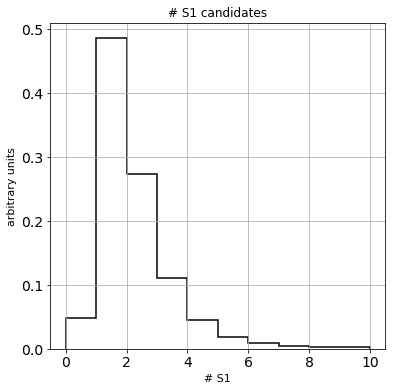

In [11]:
krf.histo_ns12(nsdst.ns1, xlabel='# S1', title = '# S1 candidates', fontsize = 11, figsize=(6,6))

In [12]:
krf.print_ns12_stats(*krf.ns1_stats(nsdst))

ns12: mean =  2.08 sigma =  7.75
ns12 : fraction
0:  0.05
1:  0.48
2:  0.27
3:  0.11
4:  0.09


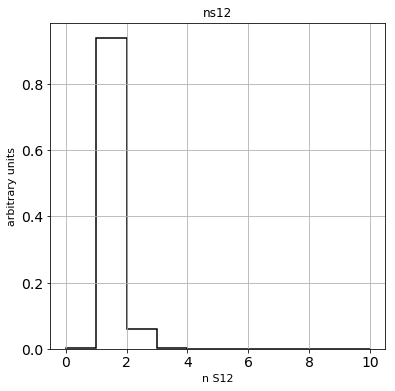

In [13]:
krf.histo_ns12(nsdst.ns2)

In [14]:
krf.print_ns12_stats(*krf.ns2_stats(nsdst))

ns12: mean =  1.06 sigma =  0.35
ns12 : fraction
0:  0.00
1:  0.94
2:  0.06
3:  0.00


In [15]:
dst_full.head()

,index,evt,tsp,ns1,es1,hs1,ws1,ts1,ns2,es2,ws2,ts2,qs2,xs2,ys2,nsi
0,0,1.0,1.521031e+12,3.0,7.629572,1.978755,125.0,350.475,1.0,14416.178453,9443.584822,652.510038,505.030932,-53.717510,-20.798041,13.0
1,1,1.0,1.521031e+12,3.0,5.787087,1.693963,100.0,350.900,1.0,14416.178453,9443.584822,652.510038,505.030932,-53.717510,-20.798041,13.0
2,2,1.0,1.521031e+12,3.0,15.432783,3.338182,150.0,513.350,1.0,14416.178453,9443.584822,652.510038,505.030932,-53.717510,-20.798041,13.0
3,3,2.0,1.521031e+12,1.0,6.374378,1.435236,125.0,558.825,1.0,13363.622649,8373.920435,652.503622,480.935622,23.578037,111.765397,13.0
4,4,3.0,1.521031e+12,1.0,7.064373,1.852627,100.0,229.875,1.0,10585.362194,12320.362898,653.470231,273.390986,82.356830,-98.911840,9.0


## S1 histos

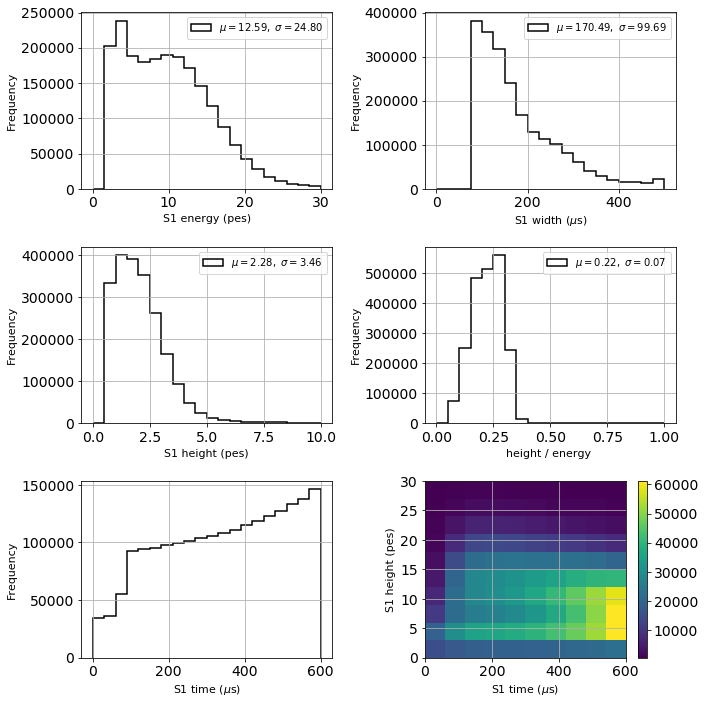

In [16]:
krf.plot_s1histos(dst_full, bins=20, figsize=(10,10))

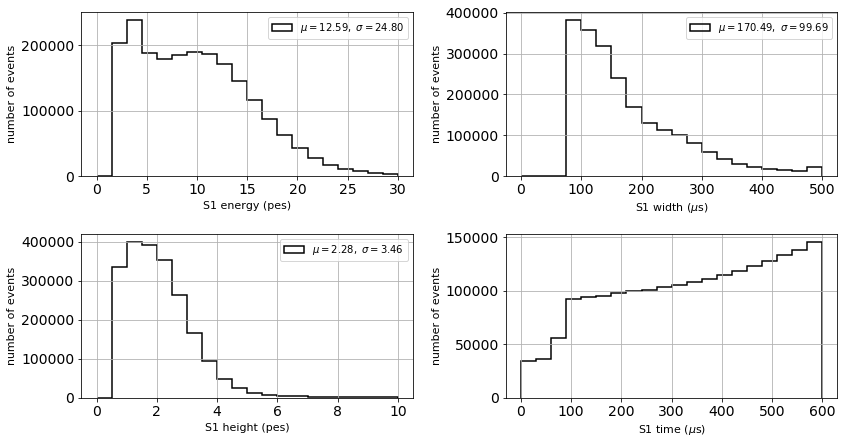

In [17]:
krf.plot_s1histos_short(dst_full, bins=20, figsize=(12,12))

## Select events with only 1 s1

In [18]:
dst1s1 = dst_full[dst_full.ns1==1]

In [19]:
dst2s1 = dst_full[dst_full.ns1==2]
dstms1 = dst_full[dst_full.ns1>2]

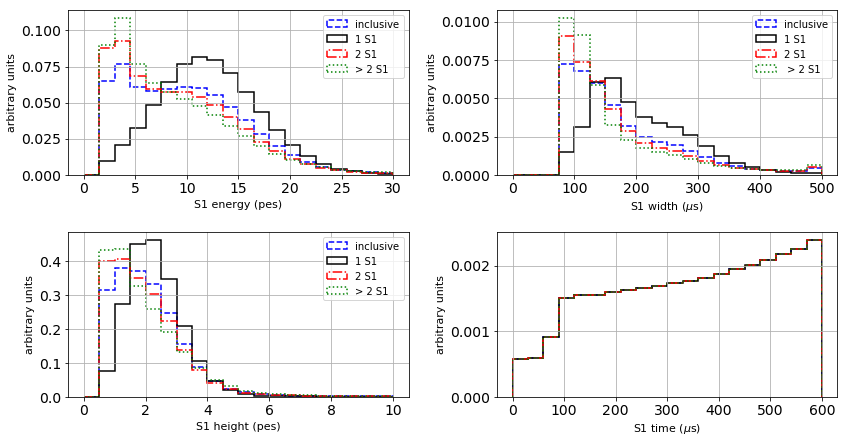

In [20]:
krf.plot_s1histos_multi(dst_full, dst1s1, dst2s1, dstms1, bins=20, figsize=(12,12))

## S1 histos again. 

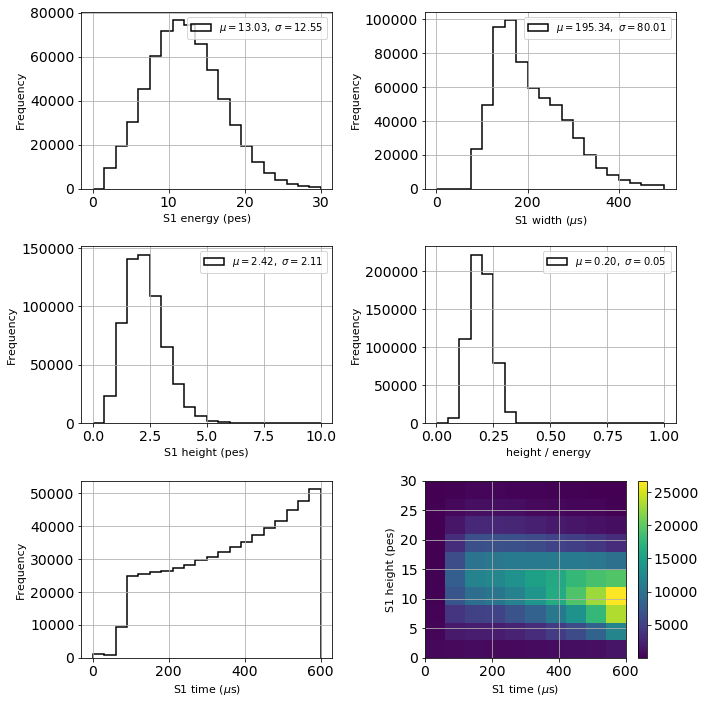

In [21]:
krf.plot_s1histos(dst1s1, bins=20, figsize=(10,10))

## Select a single S2

In [22]:
dst1s12 = dst1s1[dst1s1.ns2==1]

## S2 histos

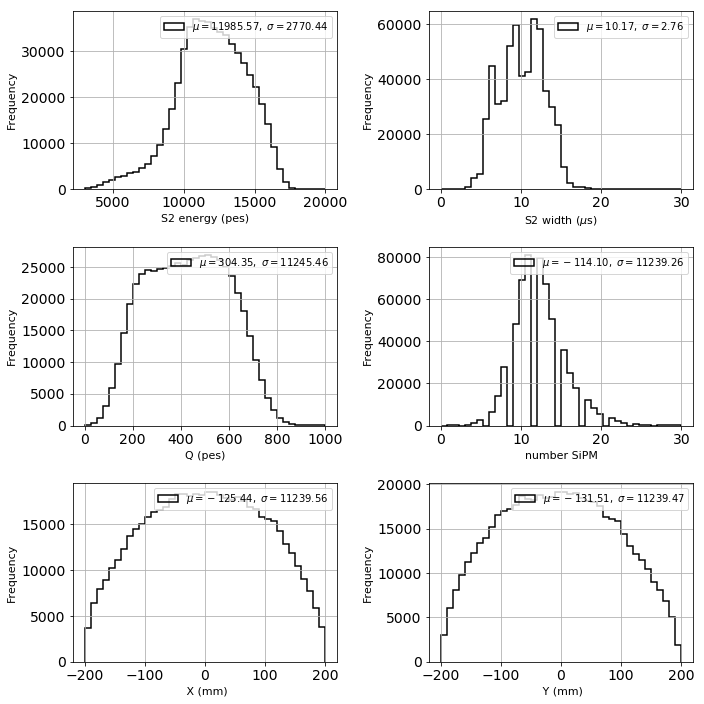

In [23]:
krf.plot_s2histos(dst1s12, bins=40, emin=3000, emax=20000, figsize=(10,10))

In [24]:
dst = dst1s12
number_of_events  = len(dst)
eff = number_of_events  / ntot 
print(f"Total number of events with 1 s1 and 1 s2 : {number_of_events}: selection eff = {eff} ")

Total number of events with 1 s1 and 1 s2 : 562002: selection eff = 0.4529008924211093 


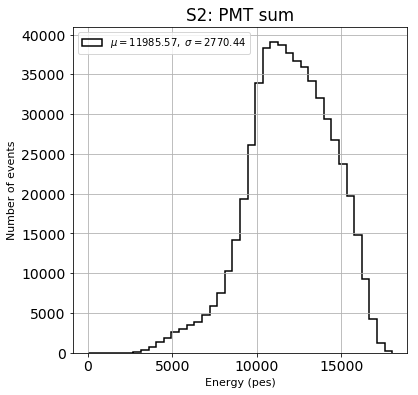

In [25]:
krf.h1d(dst.es2, bins=40, range=(0,18000), xlabel='Energy (pes)', ylabel='Number of events',
        title='S2: PMT sum', legend='upper left', figsize=(6,6))


## Define bins and ranges

In [26]:
kR = KrRanges(E  = ( 4e3, 18e3),
              Q  = (   0, 800),
              Z  = ( 100, 500),
              XY = (-200, 200)
             )

kNB = KrNBins(E  =  50,
              Q  =  25,
              Z  =  10,
              XY =  40
             )
           

In [27]:
kB  = KrBins(E   =  np.linspace(*kR.E,  kNB.E  + 1),
             Q   =  np.linspace(*kR.Q,  kNB.Q  + 1),
             Z   =  np.linspace(*kR.Z,  kNB.Z  + 1),
             XY  =  np.linspace(*kR.XY, kNB.XY + 1),
             cXY =  shift_to_bin_centers(np.linspace(*kR.XY, kNB.XY + 1))
            )

In [28]:
print(kR)

KrRanges(E=(4000.0, 18000.0), Q=(0, 800), Z=(100, 500), XY=(-200, 200))


In [29]:
print(kNB)

KrNBins(E=50, Q=25, Z=10, XY=40)


In [30]:
print(kB)

KrBins(E=array([  4000.,   4280.,   4560.,   4840.,   5120.,   5400.,   5680.,
         5960.,   6240.,   6520.,   6800.,   7080.,   7360.,   7640.,
         7920.,   8200.,   8480.,   8760.,   9040.,   9320.,   9600.,
         9880.,  10160.,  10440.,  10720.,  11000.,  11280.,  11560.,
        11840.,  12120.,  12400.,  12680.,  12960.,  13240.,  13520.,
        13800.,  14080.,  14360.,  14640.,  14920.,  15200.,  15480.,
        15760.,  16040.,  16320.,  16600.,  16880.,  17160.,  17440.,
        17720.,  18000.]), Q=array([   0.,   32.,   64.,   96.,  128.,  160.,  192.,  224.,  256.,
        288.,  320.,  352.,  384.,  416.,  448.,  480.,  512.,  544.,
        576.,  608.,  640.,  672.,  704.,  736.,  768.,  800.]), Z=array([ 100.,  140.,  180.,  220.,  260.,  300.,  340.,  380.,  420.,
        460.,  500.]), XY=array([-200., -190., -180., -170., -160., -150., -140., -130., -120.,
       -110., -100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,  -30.,
        -20.,  -10.,    0.,  

In [31]:
kre  = KrEvent(E = dst.es2.values,
              Q = dst.qs2.values,             
              X = dst.xs2  .values,
              Y = dst.ys2  .values,
              Z = dst.ts2  .values - dst.ts1  .values
              )


## Spatial distribution of events

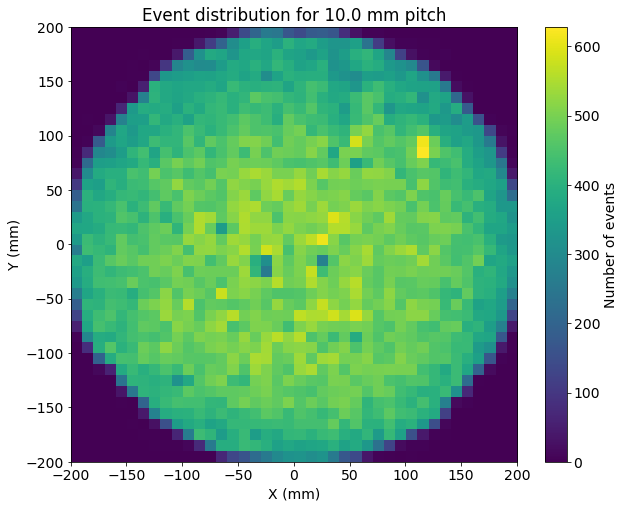

In [32]:
nevt = krf.xy_event_map(kre, kB)

### Number of entries per bin in map

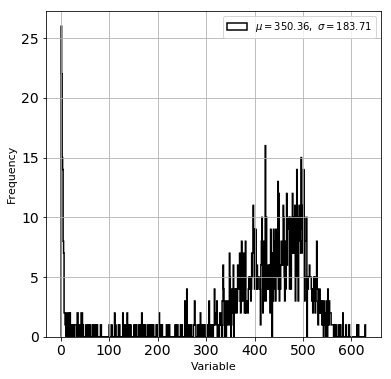

In [33]:
nevt_max = int(np.max(nevt))
krf.h1d(nevt.flatten(), np.arange(1, nevt_max + 2))
#labels("Number of events per bin", "Entries", "# events per bin")


## Fit lifetime 

#### Define limits (relevant for XY)

In [34]:
kL = KrRanges(E  = ( 4e3, 18e3),
              Q  = (   0, 800),
              Z  = ( 100, 500),
              XY = (-200, 200)
             )



fit par[0] = 14623.092344926894 error = 10.024808369223638
fit par[1] = -1273.0439467969657 error = 3.6589408733087554
chi2 = 2.533927110813453


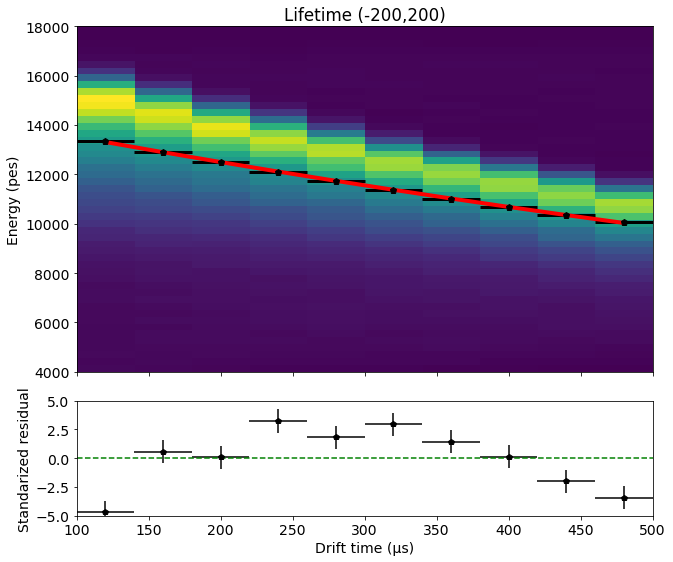

In [35]:
lt, lte, chi2 = krf.fit_lifetime_from_profile(kre, kR, kNB, kB, kL, 
                                 title="Lifetime (-200,200)")

In [36]:
eR = Ranges(
    lower  = np.zeros(10),
    upper  = np.full(10, 10**5)
)

In [41]:
eR = Ranges(
    lower  = (10e+3, 10e+3, 10e+3, 10e+3, 10e+3, 10e+3, 9e+3, 9e+3, 8e+3, 8e+3),
    upper  = (18e+3, 18e+3, 18e+3, 18e+3, 18e+3, 18e+3, 18e+3, 18e+3, 18e+3, 18e+3)
)

bin : 0, energy range for fit: lower = 10000.0, upper = 18000.0
bin : 1, energy range for fit: lower = 10000.0, upper = 18000.0
bin : 2, energy range for fit: lower = 10000.0, upper = 18000.0
bin : 3, energy range for fit: lower = 10000.0, upper = 18000.0
bin : 4, energy range for fit: lower = 10000.0, upper = 18000.0
bin : 5, energy range for fit: lower = 10000.0, upper = 18000.0
bin : 6, energy range for fit: lower = 9000.0, upper = 18000.0
bin : 7, energy range for fit: lower = 9000.0, upper = 18000.0
bin : 8, energy range for fit: lower = 8000.0, upper = 18000.0
bin : 9, energy range for fit: lower = 8000.0, upper = 18000.0


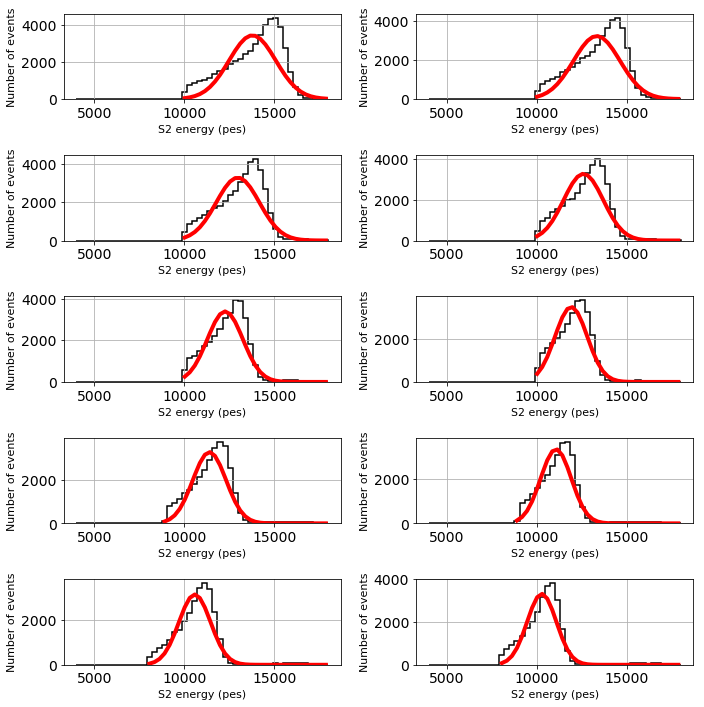

In [42]:
kf = krf.fit_s2_energy_in_z_bins_within_XY_limits(kre, kL, kNB, kB, eR,
                                             figsize=(10,10)) 

In [43]:
kf.par

array([ 13781.34655451,  13329.20863201,  12969.04686854,  12590.92394274,
        12263.30596824,  11907.63571863,  11393.55514806,  11064.88481469,
        10578.01856777,  10276.4626429 ])

In [44]:
kf.err

array([ 7.5636123 ,  7.61657555,  7.27558471,  7.02235649,  6.53642008,
        6.21769899,  6.19204898,  5.7826774 ,  6.21949066,  5.81034806])

In [45]:
kf.chi2

array([ 17.69097651,  13.9226824 ,  13.10591445,  11.78487518,
        10.842976  ,   9.99028979,  10.62870968,   9.28316058,
        10.51645872,   9.69055541])

fit par[0] = 15277.269561682637 error = 7.521626024918722
fit par[1] = -1228.3962597949835 error = 2.3158274544140407
chi2 = 11.913150980354189


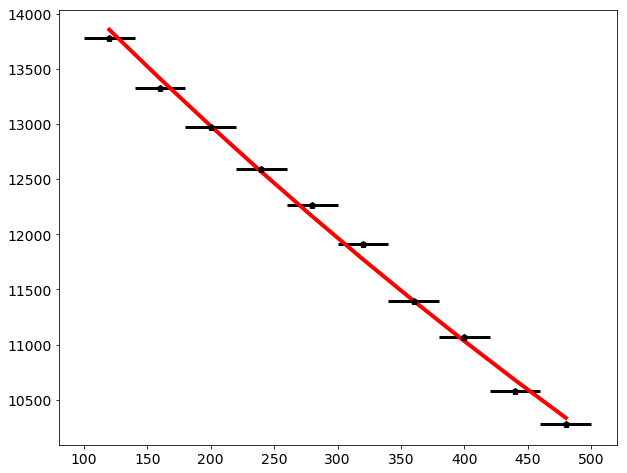

In [46]:
krf.fit_lifetime(kB, kf, title="Lifetime (-200,200)")

fit par[0] = 15739.999143527353 error = 7.568084322189656
fit par[1] = -1200.0341937806386 error = 2.405253812390805
chi2 = 1.160788483580366


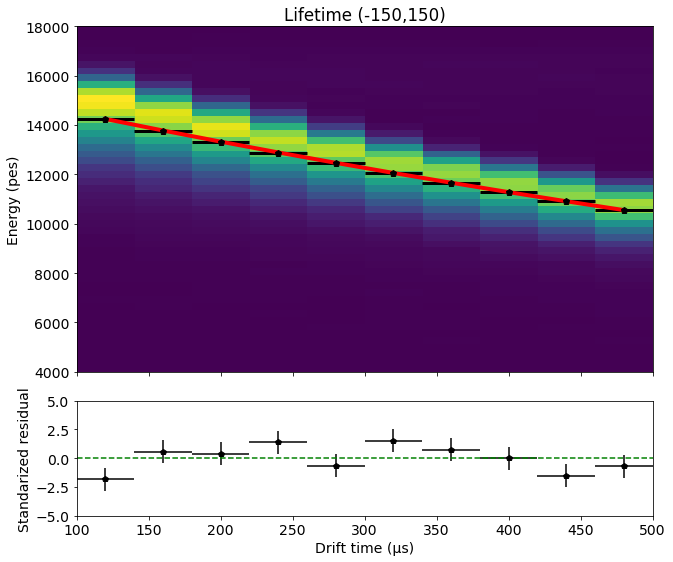

In [47]:
kL = KrRanges(E  = ( 8e3, 18e3),
              Q  = (   0, 800),
              Z  = ( 100, 500),
              XY = (-150, 150)
             )

lt, lte, chi2 = krf.fit_lifetime_from_profile(kre, kR, kNB, kB, kL, 
                                 title="Lifetime (-150,150)")

bin : 0, energy range for fit: lower = 10000.0, upper = 18000.0
bin : 1, energy range for fit: lower = 10000.0, upper = 18000.0
bin : 2, energy range for fit: lower = 10000.0, upper = 18000.0
bin : 3, energy range for fit: lower = 10000.0, upper = 18000.0
bin : 4, energy range for fit: lower = 10000.0, upper = 18000.0
bin : 5, energy range for fit: lower = 10000.0, upper = 18000.0
bin : 6, energy range for fit: lower = 9000.0, upper = 18000.0
bin : 7, energy range for fit: lower = 9000.0, upper = 18000.0
bin : 8, energy range for fit: lower = 8000.0, upper = 18000.0
bin : 9, energy range for fit: lower = 8000.0, upper = 18000.0


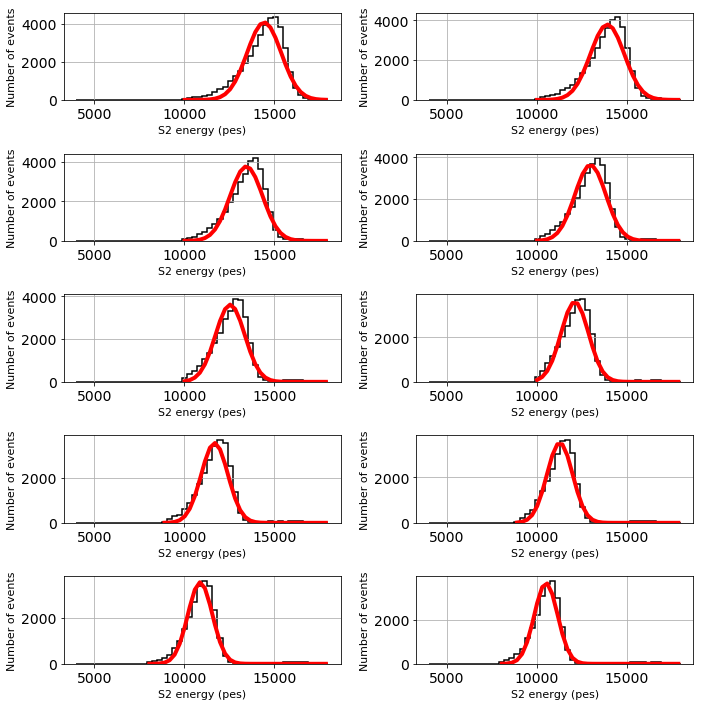

In [48]:
kf = krf.fit_s2_energy_in_z_bins_within_XY_limits(kre, kL, kNB, kB, eR,
                                             figsize=(10,10)) 

fit par[0] = 16032.99853305166 error = 5.7464115196606125
fit par[1] = -1136.4654803573178 error = 1.4896329027677553
chi2 = 1.3447269818137977


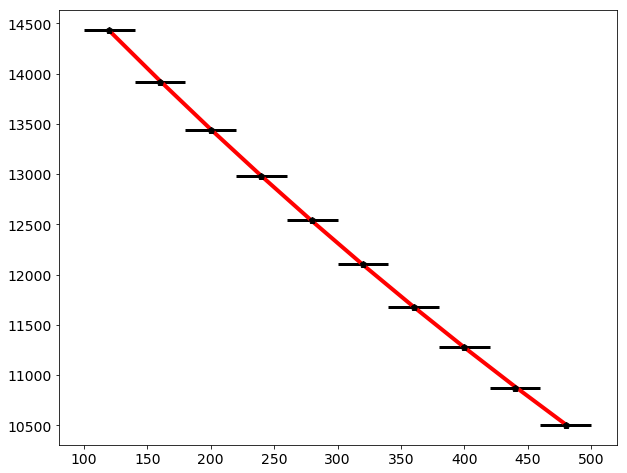

In [49]:
krf.fit_lifetime(kB, kf, title="Lifetime (-200,200)")

fit par[0] = 16647.92749617606 error = 6.543151421890886
fit par[1] = -1166.588329021039 error = 2.0868779290269863
chi2 = 1.2818398716255468


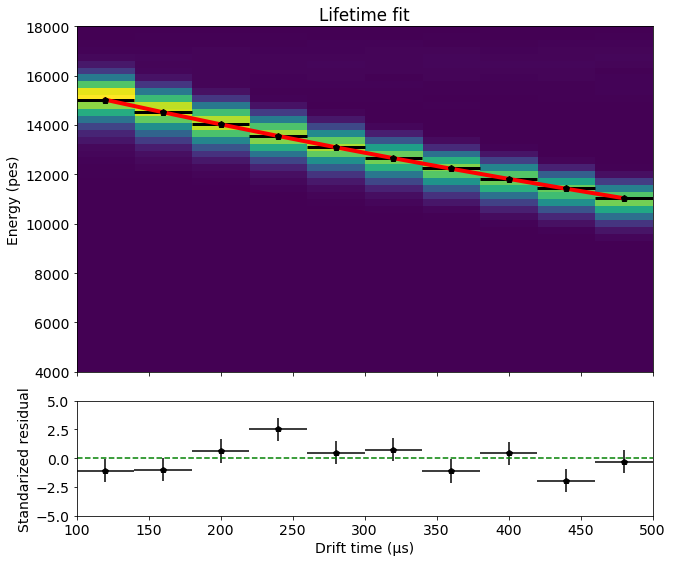

In [50]:
kL = KrRanges(E  = ( 8e3, 18e3),
              Q  = (   0, 800),
              Z  = ( 100, 500),
              XY = (-100, 100)
             )

lt, lte, chi2 = krf.fit_lifetime_from_profile(kre, kR, kNB, kB, kL, 
                                 title="Lifetime fit")

fit par[0] = 16347.794849081049 error = 4.487652364030928
fit par[1] = -933.9094854052677 error = 0.8264284873900124
chi2 = 1.5742861344374521


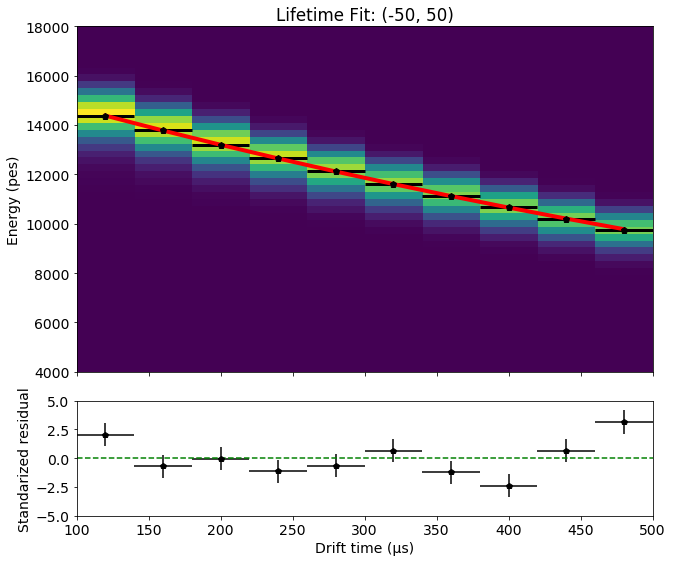

In [115]:
lt, lte, chi2 = krf.fit_lifetime_from_profile(kre, kR, kNB, kB, kL, 
                                 title="Lifetime Fit: (-50, 50)")

In [116]:
eR = Ranges(
    lower  = (12e+3, 12e+3, 11e+3, 11e+3, 10e+3, 10e+3, 9e+3, 9e+3, 8e+3, 8e+3),
    upper  = (18e+3, 18e+3, 16e+3, 16e+3, 14e+3, 14e+3, 13e+3, 13e+3, 12e+3, 12e+3)
)

bin : 0, energy range for fit: lower = 12000.0, upper = 18000.0
bin : 1, energy range for fit: lower = 12000.0, upper = 18000.0
bin : 2, energy range for fit: lower = 11000.0, upper = 16000.0
bin : 3, energy range for fit: lower = 11000.0, upper = 16000.0
bin : 4, energy range for fit: lower = 10000.0, upper = 14000.0
bin : 5, energy range for fit: lower = 10000.0, upper = 14000.0
bin : 6, energy range for fit: lower = 9000.0, upper = 13000.0
bin : 7, energy range for fit: lower = 9000.0, upper = 13000.0
bin : 8, energy range for fit: lower = 8000.0, upper = 12000.0
bin : 9, energy range for fit: lower = 8000.0, upper = 12000.0


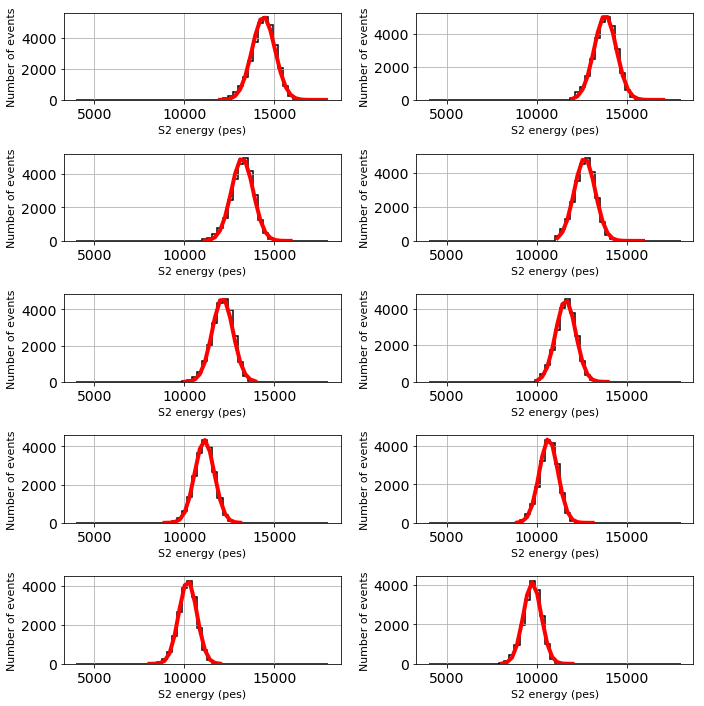

In [117]:
kf = krf.fit_s2_energy_in_z_bins_within_XY_limits(kre, kL, kNB, kB, eR,
                                             figsize=(10,10)) 

fit par[0] = 16400.6821050496 error = 4.196037395023869
fit par[1] = -925.4469589805193 error = 0.7407465442024725
chi2 = 1.9461061670549213


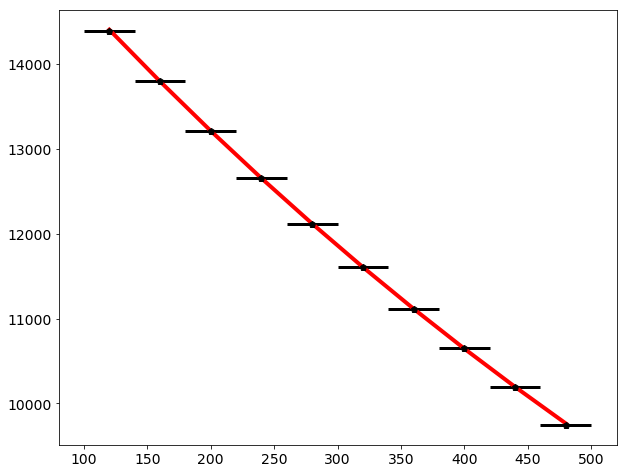

In [118]:
krf.fit_lifetime(kB, kf, title="Lifetime (-50,50)")